# C-O Yukawa Binary Mixture

In this notebook we will calculate the diffusion and interdiffusion coefficients of Binary Ionic Mixture (BIM) of Hydrogen and Helium. This notebook tries to reproduce the data obtained from Hansen, Joly, and McDonald's [paper](https://doi.org/10.1016/0378-4371(85)90022-6).

The YAML input file can be found at [input_file](https://raw.githubusercontent.com/murillo-group/sarkas/master/docs/examples/BIM/input_files/BIM_cgs.yaml).

In [1]:
# Import the usual libraries
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
plt.style.use('MSUstyle')
# Import sarkas
from sarkas.processes import PreProcess, Simulation, PostProcess


# Create the file path to the YAML input file
input_file_name = os.path.join('input_files', 'ybim_mks_pp.yaml')

In [2]:
# pre = PreProcess(input_file_name)
# pre.setup(read_yaml=True)
# pre.run(pppm_estimate=True)

In [3]:
# sim = Simulation(input_file_name)
# sim.setup(read_yaml=True)
# sim.run()

## PostProcessing


In [4]:
postproc = PostProcess(input_file_name)
postproc.setup(read_yaml=True)

### Thermodynamic Check

Let's make sure that the equilibration phase was $NVT$ and the production phase $NVE$.



=========================== Thermodynamics ===========================
Data saved in: 
 SarkasSimulations/CO_mks_pp/PostProcessing/Thermodynamics/Production/Thermodynamics_CO_mks_pp.h5
Data accessible via: self.dataframe_slices, self.dataframe

Time Series Data:
No. of blocks = 1
No. dumps per block = 40001
Total time per block: T = 2.1484e-12 [s] ~ 1191 plasma periods
Time interval: dt = 5.3709e-17 [s] ~ 3.0e-02 plasma period



Thermodynamics calculation Time: 0 sec 75 msec 205 usec 166 nsec


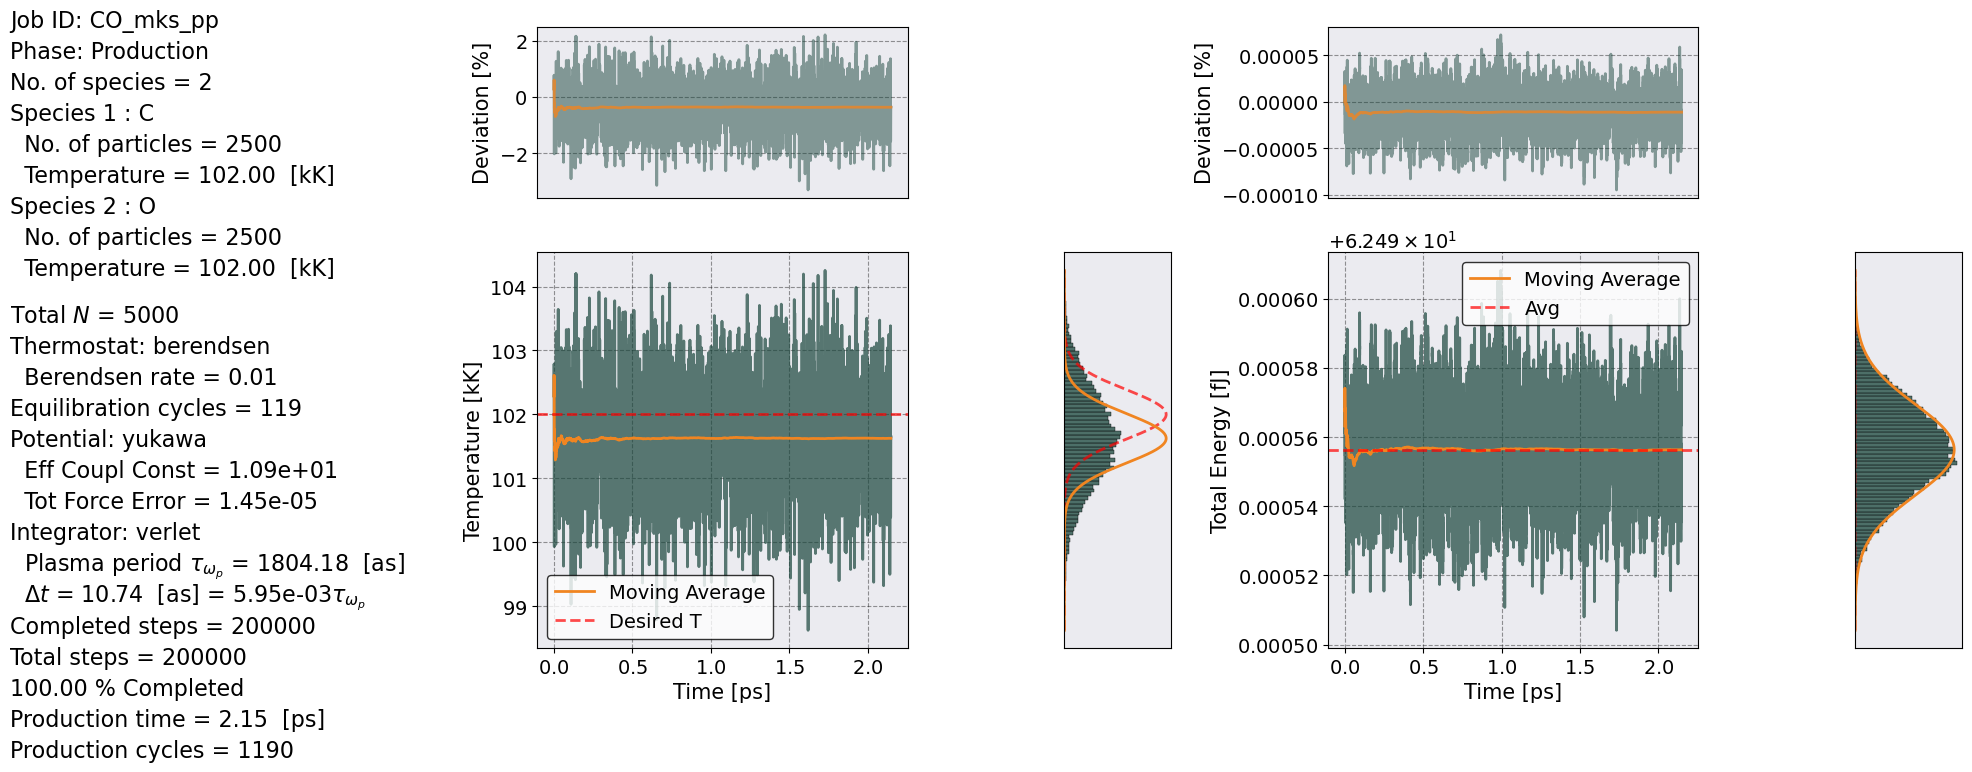

In [5]:
from sarkas.tools.observables import Thermodynamics

therm = Thermodynamics()
therm.setup(postproc.parameters, phase = 'production')
therm.compute()
therm.temp_energy_plot(postproc)


In [6]:
from astropy import units as u
import h5py

# Collect the energy of each species and store it in dictionary
species_thermodynamics_data = {key : {} for key in therm.species_names}
for k in species_thermodynamics_data.keys():
    species_thermodynamics_data[k] = { key: np.zeros(therm.no_dumps) for key in therm.thermodynamics_list}

with h5py.File(therm.h5md_filepath, 'r') as file:
    observable_group = file['observables']
    for sp_name in therm.species_names:
        species_group = observable_group[sp_name]
        
        for obs_name in therm.thermodynamics_list:
            species_thermodynamics_data[sp_name][obs_name] = species_group[obs_name]["value"][:]
            if obs_name == "temperature":
                time_data = species_group[obs_name]["time"][:]

        species_thermodynamics_data[sp_name]["time"] = time_data

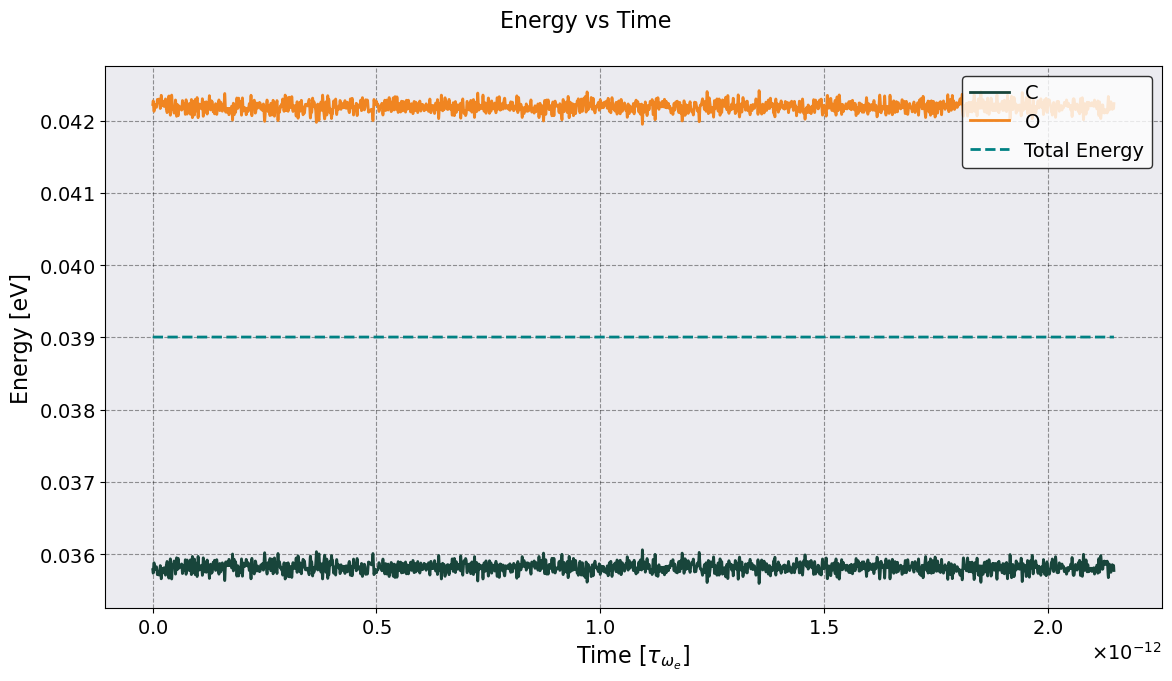

In [7]:
# Plot the energy of each species
fig_energy, ax_energy = plt.subplots(1, 1, figsize=(12, 7))
fig_energy.suptitle(f'Energy vs Time', fontsize=16)
# en = np.zeros(therm.no_dumps)
for sp_name in therm.species_names:
    ax_energy.plot(species_thermodynamics_data[sp_name]["time"], species_thermodynamics_data[sp_name]["total_energy"]*u.erg.to(u.eV), label=sp_name)
    # en += species_thermodynamics_data[sp_name]["total_energy"]*u.erg.to(u.eV)
# ax_energy.plot(species_thermodynamics_data[sp_name]["time"], en, label="Total Energy")
ax_energy.plot(therm.simulation_dataframe["Time"], 
               (therm.simulation_dataframe["Total Energy"].values * u.erg).to(u.eV), ls = '--', label="Total Energy")
ax_energy.set(xlabel=r'Time [$\tau_{\omega_{e}}$]', ylabel='Energy [eV]')
ax_energy.legend()
fig_energy.tight_layout()

### Pair Distribution Function

Let's look at $g_{\alpha \beta}(r)$. Just for fun.

In [6]:
# from sarkas.tools.observables import RadialDistributionFunction

# rdf = RadialDistributionFunction()
# rdf.setup(postproc.parameters)
# rdf.compute()
# rdf.plot(scaling = postproc.parameters.a_ws, 
#                   y = [("C-C RDF", "Mean"),
#                       ("C-O RDF", "Mean"),
#                       ("O-O RDF", "Mean")],
#                   xlabel = r'$r / a_{\rm ws}$')

In [7]:
# rdf.observable_filenames

In [8]:
# import h5py 

# with h5py.File(therm.h5md_filepath) as h5md_file:
#     print(h5md_file["particles"].keys())

In [9]:
from sarkas.tools.observables import DynamicStructureFactor

In [10]:
dsf = DynamicStructureFactor()
dsf.max_ka_value = 10
dsf.angle_averaging = 'principal_axis'
dsf.setup(postproc.parameters, no_slices=1)




====================== Dynamic Structure Factor ======================
Data saved in: 
 SarkasSimulations/CO_mks_pppm/PostProcessing/DynamicStructureFactor/Production/DynamicStructureFactor_CO_mks_pppm.h5
Data accessible via: self.dataframe_slices, self.dataframe

Time Series Data:
No. of blocks = 1
No. dumps per block = 6001
Total time per block: T = 3.2227e-13 [s] ~ 179 plasma periods
Time interval: dt = 5.3709e-17 [s] ~ 3.0e-02 plasma periodk wave vector information saved in:
 SarkasSimulations/CO_mks_pppm/PostProcessing/k_space_data/k_arrays.npz
n(k,t) data saved in: 
 SarkasSimulations/CO_mks_pppm/PostProcessing/k_space_data/nkt.h5
Data saved in: 
 SarkasSimulations/CO_mks_pppm/PostProcessing/DynamicStructureFactor/Production/DynamicStructureFactor_CO_mks_pppm.h5
Data accessible at: self.k_list, self.k_counts, self.ka_values, self.frequencies, self.dataframe

Wave vector parameters:
Smallest wave vector k_min = 2 pi / L = 3.9 / N^(1/3)
k_min = 0.1436 / a_ws = 2.9164e+09 [1/m]

A

In [11]:
dsf.compute()

Calculating DSF for slice:   0%|          | 0/1 [00:00<?, ?it/s]


Dynamic Structure Factor Calculation Time: 1 sec 908 msec 478 usec 42 nsec


In [12]:
# import pandas as pd
# # Initialize the result DataFrame with frequencies
# self = dsf
# self.dataframe = pd.DataFrame({" _ _Frequencies": self.frequencies})

# # Prepare a list to hold all the averaged DataFrames
# averaged_dfs = []

# # Transpose the DataFrame and then group
# grouped = self.dataframe_slices.T.groupby(level=["species", "k_index"])

# for sp1, sp1_name in enumerate(self.species_names):
#     for sp2, sp2_name in enumerate(self.species_names[sp1:], sp1):
#         skw_name = f"{sp1_name}-{sp2_name}"
        
#         # Iterate over all k_index values for this species pair
#         for k_index in self.dataframe_slices.columns.get_level_values('k_index').unique():
#             # Select the group for this species pair and k_index
#             group = grouped.get_group((skw_name, k_index))
            
#             # Calculate mean and std, then transpose back
#             df_mean = group.mean().T
#             df_std = group.std().T
            
#             # Extract the ka value directly from the k_index string
#             ka = float(k_index.split('=')[1].strip())
            
#             # Prepare column names
#             mean_column = f"{skw_name}_Mean_ka = {ka:.4f}"
#             std_column = f"{skw_name}_Std_ka = {ka:.4f}"
            
#             # Rename columns
#             df_mean.columns = [mean_column]
#             df_std.columns = [std_column]
            
#             # Combine mean and std
#             averaged_df = pd.concat([df_mean, df_std], axis=1)
#             averaged_dfs.append(averaged_df)

# # Concatenate all averaged DataFrames
# self.dataframe = pd.concat([self.dataframe] + averaged_dfs, axis=1)

In [13]:
# dsf.dataframe_slices.columns.get_level_values('k_index').unique()
# self.dataframe.columns
# self.dataframe_slices[skw_name].T.groupby(level=1).mean().T

In [14]:
# import h5py 
# import matplotlib as mpl

# fig, ax = plt.subplots(1,3, figsize = (16,4))
# with h5py.File(dsf.observable_filenames["hdf"]["path"], 'r') as f:
#     print(f.keys())
#     frequencies = f["frequencies"][:]
#     # print(frequencies)
#     k_values = f["k_values"][:,:]
#     print(len(k_values))
#     ka_mesh, w_mesh = np.meshgrid(k_values[:,3]*dsf.a_ws, frequencies/dsf.total_plasma_frequency)
#     for i, pair in enumerate(["C-C", "O-O", 'C-O']):
#         Skw = f[f"{pair}/slice_0"][:,:]
#         # ax[i].semilogy(frequencies/dsf.total_plasma_frequency, Skw[0,:])
#         pc = ax[i].pcolormesh(ka_mesh, w_mesh, Skw.T,
#                            shading = 'auto',
#                            norm = mpl.colors.LogNorm(vmin = 1e-22, vmax = 1e-15),
#                            )
#     # Skw = dsf.dataframe[("O-O", "Mean")]
#     # pc = ax[1].pcolormesh(ka_mesh, w_mesh, Skw,
#     #                    shading = 'auto',
#     #                    norm = mpl.colors.LogNorm(vmin = 1e-22, vmax = 1e-15),
#     #                    )
#     # Skw = dsf.dataframe[("C-O", "Mean")]
#     # pc = ax[2].pcolormesh(ka_mesh, w_mesh, Skw,
#     #                    shading = 'auto',
#     #                    norm = mpl.colors.LogNorm(vmin = 1e-22, vmax = 1e-15),
#     #                    )
# for a in ax:
#     a.set(
#         ylim = (0,5),
#        xlim = (0,2),
#        xlabel = r'$ka$',
#        ylabel = r'$\omega/\omega_p$')
# plt.colorbar(pc)

In [15]:
# dsf.k_harmonics[:10]

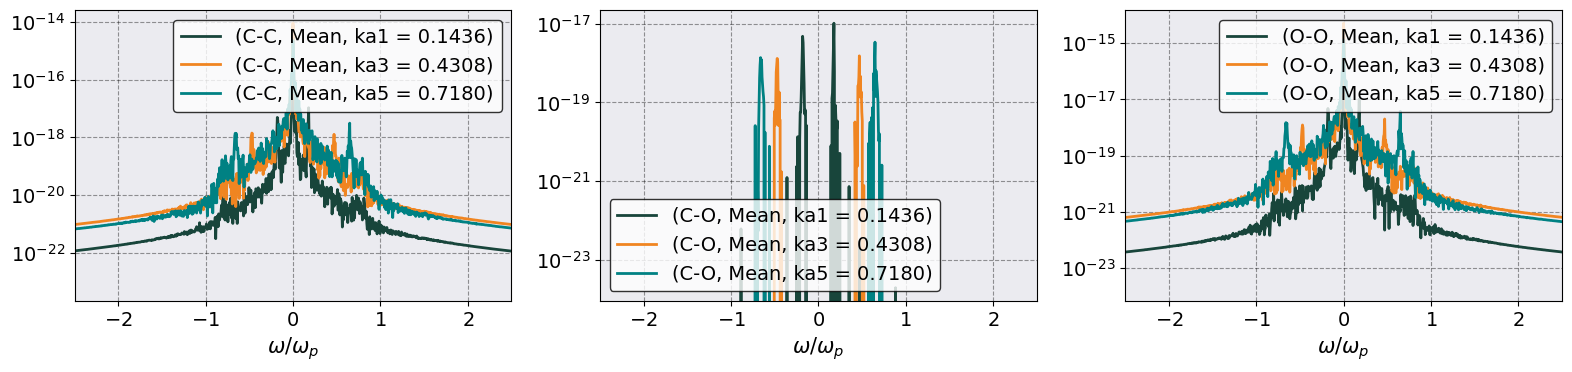

In [16]:
fig, ax = plt.subplots(1,3, figsize = (16,4))
dsf.plot(scaling = dsf.total_plasma_frequency,
         y = [("C-C","Mean", "ka1 = 0.1436"), ("C-C","Mean", "ka3 = 0.4308"), ("C-C","Mean", "ka5 = 0.7180")],
         xlabel = r'$\omega/\omega_p$',
         xlim = (-2.5, 2.5),
        logy = True,
        ax = ax[0])
dsf.plot(scaling = dsf.total_plasma_frequency,
         y = [("C-O","Mean", "ka1 = 0.1436"), ("C-O","Mean", "ka3 = 0.4308"), ("C-O","Mean", "ka5 = 0.7180")],
         xlabel = r'$\omega/\omega_p$',
         xlim = (-2.5, 2.5),
        logy = True,
        ax = ax[1])
dsf.plot(scaling = dsf.total_plasma_frequency,
         y = [("O-O","Mean", "ka1 = 0.1436"), ("O-O","Mean", "ka3 = 0.4308"), ("O-O","Mean", "ka5 = 0.7180")],
         xlabel = r'$\omega/\omega_p$',
         xlim = (-2.5, 2.5),
        logy = True,
        ax = ax[2])
for a in ax:
    a.legend()

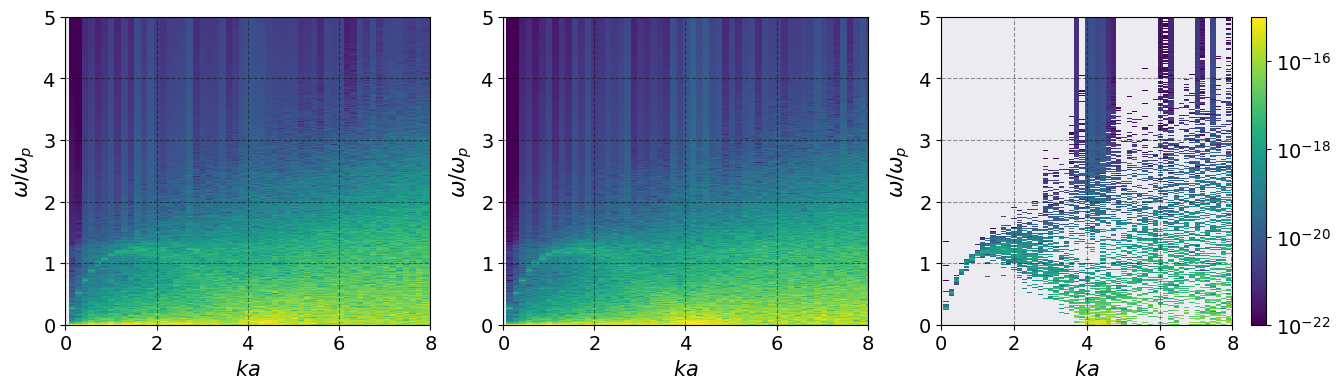

In [17]:
import matplotlib as mpl

w = dsf.dataframe[(" "," ","Frequencies")]/ dsf.species_plasma_frequencies[0]

ka_mesh, w_mesh = np.meshgrid(dsf.ka_values, w)

fig, ax = plt.subplots(1,3, figsize = (16,4))
Skw = dsf.dataframe[("C-C", "Mean")]
pc = ax[0].pcolormesh(ka_mesh, w_mesh, Skw,
                   shading = 'auto',
                   norm = mpl.colors.LogNorm(vmin = 1e-22, vmax = 1e-15),
                   )
Skw = dsf.dataframe[("O-O", "Mean")]
pc = ax[1].pcolormesh(ka_mesh, w_mesh, Skw,
                   shading = 'auto',
                   norm = mpl.colors.LogNorm(vmin = 1e-22, vmax = 1e-15),
                   )
Skw = dsf.dataframe[("C-O", "Mean")]
pc = ax[2].pcolormesh(ka_mesh, w_mesh, Skw,
                   shading = 'auto',
                   norm = mpl.colors.LogNorm(vmin = 1e-22, vmax = 1e-15),
                   )
for a in ax:
    a.set(ylim = (0,5),
       xlim = (0,8),
       xlabel = r'$ka$',
       ylabel = r'$\omega/\omega_p$')
plt.colorbar(pc)